<a href="https://colab.research.google.com/github/arsalanmubeen/IBA/blob/main/Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook consists of the material for a homework submission.

Step 1: First you will walk through code to quantize tensors. We will do a limited form of post training quantization, where we only will quantize the inputs passing between layers

What is quantization in this scenario? 

1. It means given a range of values, $X = \{x_1, x_2, \ldots x_n \}$ and a desired precision of $k$ bits. 

2. Find the minimum and maximum values of X, $x_{max}$ and $x_{min}$.

3. Find the minimum and maximum value of the bits, namely $q_{min}=0$ and $q_{max} = 2^k - 1$.

4. Set $scale = (x_{max} - x_{min}) / q_{max}$.

5. Note that besides scaling, we also have to consider the _bias_ , or what $0$ will map to. Set $zeropoint$ as follows: 

  a. If $-x_{min} / scale \leq q_{min}$, $zeropoint = q_{min}$ \
  b. Else if $-x_{min} / scale > q_{max}$, $zeropoint = q_{max}$.  
  c. Else $zeropoint = int(- x_{min} / scale)$. \

  d. https://docs.openvinotoolkit.org/latest/pot_compression_algorithms_quantization_README.html

6. The formula for quantization of $x$ then becomes:
$Q(x, bits)=round \left(\frac{x}{scale} + zeropoint \right)$.

7. The formula to dequantize becomes:
$D_Q(x, scale, zeropoint, numbits) = scale* \left(float(x) - zeropoint \right)$.




We work through a quick example. Consider the values $X = [1,3,4,14]$, $k = 4$. \
Then $q_{max} = 15$ and $scale = 13/15$. $zeropoint = 0$. \
The quantization becomes: $round([15/13, 45/13, 60/13, 210/13]) = [1,3,5,16]$ clamped to $[1,3,5,15]$. 

The dequantization becomes $\frac{13}{15} * ([1,3,5,15]) = [0.86, 2.6, 4.33, 13]$.


Qs 1.) Now fill out the following two functions to carry out quantization and dequantization. Verify for the example, but also one or two other reasonable tensors. You may need to use the clamp_ function in `quantize_tensor`, to make sure data remains in the range of $q_{min}$ to $q_{max}$. See https://pytorch.org/docs/stable/tensors.html




Qs 1.) Now fill out the following two functions to carry out quantization and dequantization. Verify for the example, but also one or two other reasonable tensors. You may need to use the clamp_ function in `quantize_tensor`, to make sure data remains in the range of $q_{min}$ to $q_{max}$. See https://pytorch.org/docs/stable/tensors.html

In [ ]:
from collections import namedtuple
from torch import tensor

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val, num_bits=8):
  # Return scale and zero point.
  # Use formulas 3 and 4 above.
  qmin = 0.
  qmax = 2.**num_bits - 1.
  scale = (max_val - min_val) / qmax 
  initial_zero_point = ( -min_val / scale)
  zero_point = 0

  if initial_zero_point <= qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)
  return scale, zero_point, qmin, qmax

def quantize_tensor(float_x: tensor, num_bits: int):
  #pass
  # Return a QTensor tuple, with the quantized tensor, scale and zero point as described above.
  # Use calcScaleZeroPoint and formula 6 above.
  min_val=None
  max_val=None
  if not min_val and not max_val: 
      min_val, max_val = float_x.min(), float_x.max()
  
  scale, zero_point, qmin, qmax = calcScaleZeroPoint(min_val, max_val, num_bits)
  q_x = zero_point + float_x / scale
  q_x.clamp_(qmin, qmax).round_()
  q_x = q_x.round()

  return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)


def dequantize_tensor(quantized_x: tensor, scale: float, zero_point: float , num_bits: int):
  #pass
  # Return float_tensor. 
  return scale * (quantized_x.float() - zero_point)

# MNIST
We now train a basic MNIST model. This code is filled in for you, you do not need to edit this.

In [ ]:
# You don't need to edit any of this code.
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self, mnist=True):
      
        super(Net, self).__init__()
        if mnist:
          num_channels = 1
        else:
          num_channels = 3
          
        self.conv1 = nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
      
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# You don't need to edit any of the code here.
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
   
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def main():
 
    batch_size = 64
    test_batch_size = 64
    epochs = 5
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 500
    save_model = False
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
    
  
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    for epoch in range(1, epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")
    
    return model

model = main()


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292215
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.254183

Test set: Average loss: 0.1176, Accuracy: 9635/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.127291
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.055466

Test set: Average loss: 0.0749, Accuracy: 9746/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.058363
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.028524

Test set: Average loss: 0.0510, Accuracy: 9847/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.041871
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.020632

Test set: Average loss: 0.0456, Accuracy: 9836/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.025634
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.010120

Test set: Average loss: 0.0323, Accuracy: 9888/10000 (99%)



The below is test functions for your code. You should not need to edit these. Make sure your `quantize_tensor` function is returning a QTensor namedtuple.

In [ ]:
# These are driver functions for your code. You do not need to edit.
def quantForward(model, input, num_bits):
  quantized_input = quantize_tensor(input, num_bits)
  output_1  = F.relu(model.conv1(quantized_input.tensor))
  output_2 = F.max_pool2d(quantize_tensor(output_1, num_bits).tensor, 2, 2)
  output_3 = F.relu(model.conv2(quantize_tensor(output_2, num_bits).tensor))
  output_4 = F.max_pool2d(quantize_tensor(output_3, num_bits).tensor, 2, 2)
  output_5 = output_4.view(-1, 4*4*50)
  output_6 = F.relu(model.fc1(quantize_tensor(output_5, num_bits).tensor))
  output_7 = model.fc2(quantize_tensor(output_6, num_bits).tensor)
  return F.log_softmax(quantize_tensor(output_7, num_bits).tensor, dim=1)

def testQuant(model, test_loader, quant=False, num_bits=8):
    device = 'cuda'
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if quant:
              output = quantForward(model, data, num_bits)
            else:
              output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    AccuracyPer = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        AccuracyPer))
    return  num_bits, AccuracyPer

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

Qs. 2 Can you plot how the accuracy changes as you alter the number of bits used for quantization? Try values between 1 and 16 bits.

In [ ]:
testQuant(model, test_loader, quant=True, num_bits=2)


Test set: Average loss: 1.4494, Accuracy: 8588/10000 (86%)




Test set: Average loss: 2.2914, Accuracy: 1078/10000 (11%)


Test set: Average loss: 1.4492, Accuracy: 8525/10000 (85%)


Test set: Average loss: 0.6727, Accuracy: 9609/10000 (96%)


Test set: Average loss: 0.1608, Accuracy: 9846/10000 (98%)


Test set: Average loss: 0.0405, Accuracy: 9875/10000 (99%)


Test set: Average loss: 0.0358, Accuracy: 9885/10000 (99%)


Test set: Average loss: 0.0608, Accuracy: 9886/10000 (99%)


Test set: Average loss: 0.1169, Accuracy: 9888/10000 (99%)


Test set: Average loss: 0.2321, Accuracy: 9887/10000 (99%)


Test set: Average loss: 0.4660, Accuracy: 9888/10000 (99%)


Test set: Average loss: 0.9320, Accuracy: 9887/10000 (99%)


Test set: Average loss: 1.8594, Accuracy: 9887/10000 (99%)


Test set: Average loss: 3.7421, Accuracy: 9888/10000 (99%)


Test set: Average loss: 7.3952, Accuracy: 9888/10000 (99%)


Test set: Average loss: 14.5492, Accuracy: 9888/10000 (99%)


Test set: Average loss: 29.7690, Accuracy: 9888/10000 (99%)



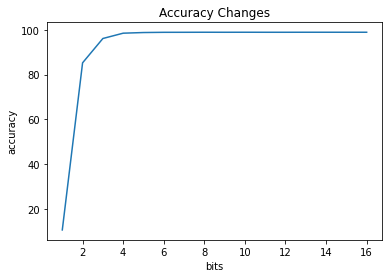

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
mylist=[]

for x in range(1, 17):
    mylist.append(testQuant(model, test_loader, quant=True, num_bits=x))

df=pd.DataFrame(mylist) 
plt.plot(df[0], df[1])
plt.title('Accuracy Changes')
plt.xlabel('bits')
plt.ylabel('accuracy')
plt.show()